# Imports and reading the data

In [41]:
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches 
import random
from collections import defaultdict
from shapely.geometry import Polygon
import operator
import EoN

seed = 27

In [2]:
#reading the data
df = pd.read_csv('escorts.txt', delim_whitespace=True, index_col=False)

df_copy = df.copy()

#creating new columns in df that adds: year, month and day
df_copy['datetime'] = pd.to_datetime(df_copy['timestamp'], unit='s')

df_copy['year'] = df_copy['datetime'].dt.year
df_copy['month'] = df_copy['datetime'].dt.month
df_copy['day'] = df_copy['datetime'].dt.day

#dropping column datetime
df_copy = df_copy.drop(columns=['datetime'])

#getting rid of the timestamp
df_no_time = df.drop('timestamp', axis=1)
df_no_time.to_csv('escorts.csv', index =False, header=False)

df_no_time


,n1,n2,e
0,1,1,0
1,1,2,1
2,1,3,0
3,2,1,0
4,3,4,0
...,...,...,...
50627,8491,6621,0
50628,9136,6622,1
50629,6325,6456,1
50630,10105,6623,1


### Creating graphs

In [3]:
#creating different IDs for buyers(a) and escorts(b), so the nx function could read it
df_no_time['n1'] = 'a' + df_no_time['n1'].astype(str)

df_no_time['n2'] = 'b' + df_no_time['n2'].astype(str)

#collapsing the edges where one buyer rated the same girl more than 1 time
main_df = df_no_time.groupby(['n1', 'n2'], as_index=False).mean() #yes, it creates the means if they went to more than one escort
main_df


,n1,n2,e
0,a1,b1,0.0
1,a1,b1057,-1.0
2,a1,b12,0.0
3,a1,b130,-1.0
4,a1,b1340,-1.0
...,...,...,...
39039,a9996,b1503,1.0
39040,a9997,b125,1.0
39041,a9998,b1569,1.0
39042,a9998,b4791,1.0


In [4]:
n1_list = main_df['n1'].tolist()
n2_list = main_df['n2'].tolist()

In [5]:
#projecting the bipartite graph using vectorized projection
G = nx.from_pandas_edgelist(main_df, 'n1', 'n2', 'e')

#projecting onto the escorts
proj_G = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n2.unique(), ratio=True) #ratio is number of common neighbors devided by number of buyers

#projecting onto the buyers
proj_G_b = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n1.unique(), ratio=True)

# Functions

In [6]:
def give_condom(df, buyers_list):
    '''
    Function that gives condom to all the buyers in buyers_list
    and returns the DataFrame with updated edge
    '''


    mask = df['n1'].isin(buyers_list)
    df.loc[mask, 'e'] = 0.365*(1-0.8)

    return df

In [7]:

def count_unique_person2(df):
    """
    Count the unique person2 for each person1 and return a dictionary.

    Parameters:
    - df: pandas DataFrame with columns 'person1' and 'person2'

    Returns:
    - Dictionary with person1 as key and the count of unique person2 as value
    """

    # Group by 'person1' and count unique values in 'person2' for each group
    result_df = df.groupby('n1')['n2'].nunique().reset_index()

    # Convert the result to a dictionary
    result_dict = dict(zip(result_df['n1'], result_df['n2']))
    sorted_result_dict = dict(sorted(result_dict.items(), key=operator.itemgetter(1), reverse=True))


    return sorted_result_dict

top_b_links = count_unique_person2(df_no_time)

In [10]:
def weightz(G, u, v):
    ''' 
    Assigns weights to the edges in the projected graph based on the average weight of edges between
    u, v and their common neighbors in the original graph.

    Arguments:
        G : graph
            A NetworkX undirected bipartite graph.

        u, v : nodes
            Nodes in the graph.

    Returns:
        w: float

    Raises:
        NetworkXError
            If u or v is not a node in the graph.
    '''
    if u not in G:
        raise nx.NetworkXError("u is not in the graph.")
    if v not in G:
        raise nx.NetworkXError("v is not in the graph.")

    w = 0
    nbrs = nx.common_neighbors(G, u, v)
    for i, n in enumerate(nbrs):
        w += G.get_edge_data(u, n).get('e')
        w += G.get_edge_data(v, n).get('e')
    w = w/(2*(i+1))
    return w
    

## Degree distribution

In [13]:
#degrees in the bipartite network
bi_escorts_degrees = Counter(main_df['n2'])

bi_buyers_degrees = Counter(main_df['n1'])

#degrees in the projected
escorts_degrees = dict(proj_G.degree())
buyers_degrees = dict(proj_G_b.degree())

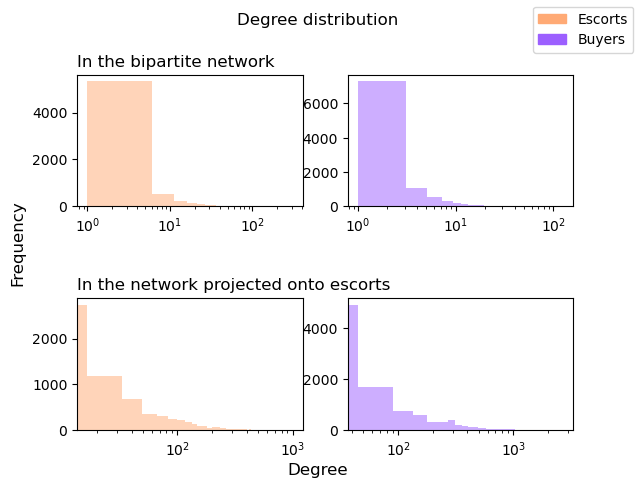

In [14]:
#Plotting degree distribution
fig, ax = plt.subplots(2, 2)

ax[0, 0].hist(bi_escorts_degrees.values(), bins=60, alpha=0.5, label='Escorts', color='#FFAA75')
ax[0,0].set_xscale('log')

ax[0, 1].hist(bi_buyers_degrees.values(), bins=60, alpha=0.5, label='Buyers', color = '#9C5FFF')
ax[0,1].set_xscale('log')

ax3 = ax[1, 0].hist(escorts_degrees.values(), bins=60, alpha=0.5, label='Escorts', color ='#FFAA75')
ax[1,0].set_xscale('log')

ax4 = ax[1, 1].hist(buyers_degrees.values(), bins=60, alpha=0.5, label='Buyers', color = '#9C5FFF')
ax[1,1].set_xscale('log')

fig.supxlabel('Degree')
fig.supylabel('Frequency')

green_patch = mpatches.Patch(color='#FFAA75', label='Escorts') 
blue_patch = mpatches.Patch(color='#9C5FFF', label='Buyers') 
fig.legend(handles=[green_patch, blue_patch], loc='upper right') 
ax[0,0].set_title('In the bipartite network', loc='left')
ax[1,0].set_title('In the network projected onto escorts', loc='left')
fig.suptitle('Degree distribution')
fig.subplots_adjust(hspace=0.7, top=0.85)

plt.show()

### Degree centrality

In [71]:
d_cent = nx.degree_centrality(proj_G)

#top 10
d_c_sorted = {k: v for k, v in sorted(d_cent.items(), key=lambda item: item[1], reverse=True)[:10]}
peri1 = {k: v for k, v in sorted(d_cent.items(), key=lambda item: item[1], reverse=False)if v >0.00030197795560924054}
peri = {k: v for k, v in sorted(peri1.items(), key=lambda item: item[1], reverse=False)[:10]}
peri

{'b491': 0.0004529669334138608,
 'b1284': 0.0004529669334138608,
 'b538': 0.0004529669334138608,
 'b2682': 0.0004529669334138608,
 'b2159': 0.0004529669334138608,
 'b565': 0.0004529669334138608,
 'b595': 0.0004529669334138608,
 'b897': 0.0004529669334138608,
 'b337': 0.0004529669334138608,
 'b826': 0.0004529669334138608}

# Creating different spread models

In [16]:
## PURE RAW SEX
#CONSTANT INFECTION RATE 0.365

# 1. updating all edges in bipartite network to have 0.365
df_constant = main_df.copy()
df_constant.loc[df_constant['e'] < 2, 'e'] = 0.365

# 2. Assign random/constant probability of wearing condom on all the male buyers. Change infection rate (edgeweight) according to this.

dic_condoms = {}
male_buyers = df_constant['n1'].unique().tolist()

for buyer in male_buyers:
    p_or_n = random.randint(0,1)
    dic_condoms[buyer] = p_or_n

df_condoms = df_constant.copy()

for key, value in dic_condoms.items():
    if value == 1:
        df_condoms.loc[df_condoms['n1'] == key, 'e'] = 0.365*(1-0.8)
    

In [17]:
#projecting graph with custom weights between escorts
G_raw = nx.from_pandas_edgelist(df_constant, 'n1', 'n2', 'e')
pG_raw = nx.bipartite.generic_weighted_projected_graph(G_raw, nodes = main_df.n2.unique(), weight_function=weightz)


In [18]:
#projecting graph with custom weights between escorts
G_condoms = nx.from_pandas_edgelist(df_condoms, 'n1', 'n2', 'e')
pG_condoms = nx.bipartite.generic_weighted_projected_graph(G_condoms, nodes = main_df.n2.unique(), weight_function=weightz)


## Degree Centrality for buyers

In [19]:

d_cent_b = nx.bipartite.degree_centrality(G, nodes = df_no_time.n1.unique())
filtered_d = {key: value for key, value in d_cent_b.items() if key.startswith('a')}
d_c_b_sorted = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)}

half = int(len(filtered_d)/2)

top_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[:half]}
bottom_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[half:]}

# b_cent_b = nx.bipartite.betweenness_centrality(G, nodes = df_no_time.n1.unique())
# filtered_b = {key: value for key, value in b_cent_b.items() if key.startswith('a')}
# b_c_b_sorted = {k: v for k, v in sorted(filtered_b.items(), key=lambda item: item[1], reverse=True)[:10]}
# print(b_c_b_sorted.keys())

# c_cent_b = nx.bipartite.closeness_centrality(G, nodes = df_no_time.n1.unique())
# filtered_c = {key: value for key, value in c_cent_b.items() if key.startswith('a')}
# c_c_b_sorted = {k: v for k, v in sorted(filtered_c.items(), key=lambda item: item[1], reverse=True)[:10]}
# print(c_c_b_sorted.keys())



# # Merging all 4 hub detection techniques to find unique hubs they present
# hubs = list(b_c_b_sorted.keys()) + list(d_c_b_sorted.keys()) + list(c_c_b_sorted.keys())
# hubs = set(hubs)
# len(hubs)




In [20]:
df_tophalf_condoms = give_condom(df_constant.copy(), list(top_half))
df_bottomhalf_condoms = give_condom(df_constant.copy(), list(bottom_half))


In [83]:
#projecting graph with custom weights between escorts
G_b_top = nx.from_pandas_edgelist(df_tophalf_condoms, 'n1', 'n2', 'e')
pG_b_top = nx.bipartite.generic_weighted_projected_graph(G_b_top, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)



In [84]:
#projecting graph with custom weights between escorts
G_b_bottom = nx.from_pandas_edgelist(df_bottomhalf_condoms, 'n1', 'n2', 'e')
pG_b_bottom = nx.bipartite.generic_weighted_projected_graph(G_b_bottom, nodes = df_bottomhalf_condoms.n2.unique(), weight_function= weightz)

## SI model

In [ ]:
degrees = nx.degree(pG_condoms)

n = 0
for key, value in degrees:
    if value == 0:
        n += 1

max_infected = round(100-(n/len(pG_condoms.nodes)*100),2)
print(f'Max possible percentage of infected nodes is {max_infected}%.')

Max possible percentage of infected nodes is 94.19%.


In [ ]:
basic_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_condoms = set(random.sample(list(set(pG_condoms.nodes)), 3))
   i_nodes_raw = i_nodes_condoms.copy()
   for step in range(50):
      i_nodes_condoms = si_simple(pG_condoms, i_nodes_condoms)
      i_nodes_raw = si_simple(pG_raw, i_nodes_raw)
      # Since we run 10 times, we average the infected set size
      basic_curve["condoms"][step] += (len(i_nodes_condoms) / len(pG_condoms.nodes)) * 10
      basic_curve["raw"][step] += (len(i_nodes_raw) / len(pG_raw.nodes)) * 10
      basic_curve['condoms_S'][step] = 100 - basic_curve["condoms"][step]

In [148]:
#we can see that after reaching 92% infected nodes increase very slowly, so we use that to compare

speed = round(whos_faster(basic_curve['condoms'], basic_curve['raw']),3)
print(f'Raw model was {speed} times faster than Condom model in reaching 92% infection rate.')

AttributeError: 'list' object has no attribute 'items'

In [80]:
third = int(len(filtered_d)/3)

top_3_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[:third]}
bottom_3_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[third:]}

seventy = int(len(filtered_d) - (len(filtered_d)/3))

top_7_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[:seventy]}
bottom_7_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[seventy:]}

In [81]:
df_tophalf_3 = give_condom(df_constant.copy(), list(top_3_half))
df_bottomhalf_3 = give_condom(df_constant.copy(), list(bottom_3_half))

df_tophalf_7 = give_condom(df_constant.copy(), list(top_7_half))
df_bottomhalf_7 = give_condom(df_constant.copy(), list(bottom_7_half))

In [87]:
G_top_3 = nx.from_pandas_edgelist(df_tophalf_3, 'n1', 'n2', 'e')
pG_top_3 = nx.bipartite.generic_weighted_projected_graph(G_top_3, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)

G_bottom_3 = nx.from_pandas_edgelist(df_bottomhalf_3, 'n1', 'n2', 'e')
pG_bottom_3 = nx.bipartite.generic_weighted_projected_graph(G_bottom_3, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)


G_top_7 = nx.from_pandas_edgelist(df_tophalf_7, 'n1', 'n2', 'e')
pG_top_7 = nx.bipartite.generic_weighted_projected_graph(G_top_7, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)

G_bottom_7 = nx.from_pandas_edgelist(df_bottomhalf_7, 'n1', 'n2', 'e')
pG_bottom_7 = nx.bipartite.generic_weighted_projected_graph(G_bottom_7, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)

## Friends paradox

# SIS model

In [ ]:
#Basic SI model usin eon library
#SIS model 
#big plot

In [151]:
#Basic SI
basic_curve = {}
labels = ['condoms', 'raw']
graphs = [pG_condoms, pG_raw]
for i,l in enumerate(labels):
    i_nodes_condoms = set(random.sample(list(set(graphs[i].nodes)), 3))
    t, S, I = EoN.fast_SIS(graphs[i], tau=0.99, gamma =0, initial_infecteds=i_nodes_condoms, tmax=50, transmission_weight = 'weight')
    basic_curve[l] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]

In [152]:
hp_basic_curve = {}
labels = ['hubs', 'peri']
i_nodes_hubs = set(random.sample(list(d_c_sorted.keys()), 3))
i_nodes_peri = set(random.sample(list(peri.keys()), 3))

t, S, I = EoN.fast_SIS(pG_condoms, tau=0.99, gamma =0, initial_infecteds=i_nodes_hubs, tmax=50, transmission_weight = 'weight')
hp_basic_curve['hubs'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]

t, S, I = EoN.fast_SIS(pG_condoms, tau=0.99, gamma =0, initial_infecteds=i_nodes_peri, tmax=50, transmission_weight = 'weight')
hp_basic_curve['peri'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]

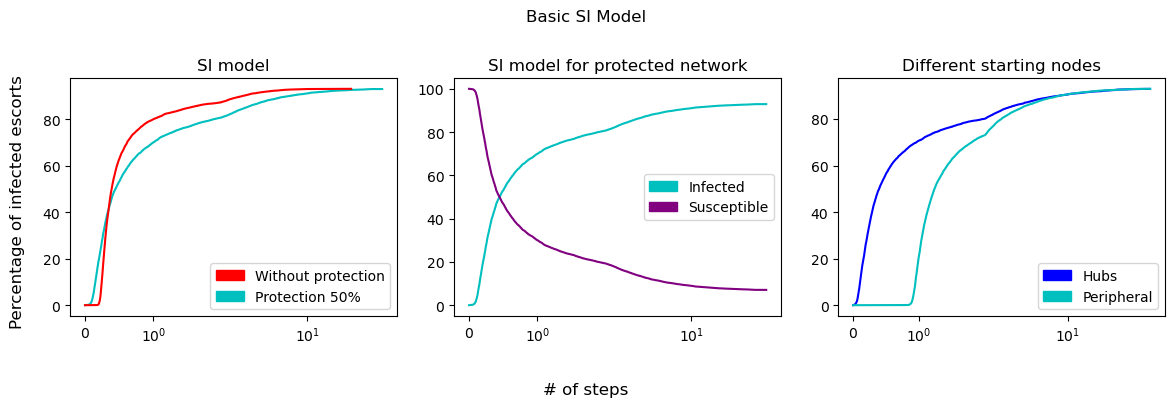

In [153]:
#Plotting simple SI model
fig, ax = plt.subplots(1, 3, figsize =(12,4))

ax[0].plot(basic_curve["condoms"][0], basic_curve["condoms"][2] ,color = 'c', label = 'Condoms')
ax[0].plot(basic_curve["raw"][0], basic_curve["raw"][2] , color = 'r', label = 'Raw')
ax[0].set_xscale('symlog')
green_patch = mpatches.Patch(color='c', label='Protection 50%') 
blue_patch = mpatches.Patch(color='r', label='Without protection') 
ax[0].legend(handles=[blue_patch, green_patch], loc='lower right')
ax[0].set_title('SI model')

ax[1].plot(basic_curve["condoms"][0], basic_curve["condoms"][2] , color = 'c', label = 'Infected')
ax[1].plot(basic_curve["condoms"][0], basic_curve["condoms"][1] , color = 'purple', label = 'Susceptible')
ax[1].set_xscale('symlog')
green_patch = mpatches.Patch(color='c', label='Infected') 
purple_patch = mpatches.Patch(color='purple', label='Susceptible')
ax[1].legend(handles=[green_patch, purple_patch], loc='center right')
ax[1].set_title('SI model for protected network')

ax[2].plot(hp_basic_curve["hubs"][0], hp_basic_curve["hubs"][2], color = 'b', label = 'Hubs')
ax[2].plot(hp_basic_curve["peri"][0], hp_basic_curve["peri"][2], color = 'c', label = 'Peri')
ax[2].set_xscale('symlog')
green_patch = mpatches.Patch(color='b', label='Hubs') 
blue_patch = mpatches.Patch(color='c', label='Peripheral') 
ax[2].legend(handles=[green_patch, blue_patch], loc='lower right')
ax[2].set_title('Different starting nodes')


fig.supxlabel('# of steps')
fig.supylabel('Percentage of infected escorts')
fig.suptitle('Basic SI Model')

fig.tight_layout(pad =1.5)

plt.show()


In [150]:
# SIS model basic

basic_curve = {}
labels = ['condoms', 'raw']
graphs = [pG_condoms, pG_raw]
for run in range(10):
    for i,l in enumerate(labels):
        i_nodes_condoms = set(random.sample(list(set(graphs[i].nodes)), 3))
        t, S, I = EoN.fast_SIS(graphs[i], tau=0.99, gamma =0.3, initial_infecteds=i_nodes_condoms, tmax=50, transmission_weight = 'weight')
        basic_curve[l] = [t/10, (S/len(pG_raw.nodes))*10, (I/len(pG_raw.nodes))*10]

KeyboardInterrupt: 

In [72]:
hp_basic_curve = {}
labels = ['hubs', 'peri']
i_nodes_hubs = set(random.sample(list(d_c_sorted.keys()), 3))
i_nodes_peri = set(random.sample(list(peri.keys()), 3))

t, S, I = EoN.fast_SIS(pG_condoms, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_hubs, tmax=50, transmission_weight = 'weight')
hp_basic_curve['hubs'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]

t, S, I = EoN.fast_SIS(pG_condoms, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_peri, tmax=50, transmission_weight = 'weight')
hp_basic_curve['peri'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]

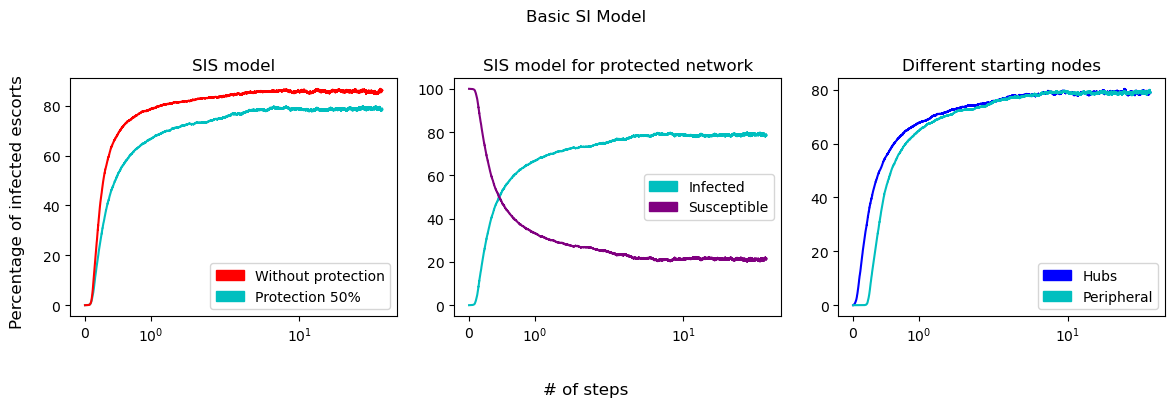

In [73]:
#Plotting simple SI model
fig, ax = plt.subplots(1, 3, figsize =(12,4))

ax[0].plot(basic_curve["condoms"][0], basic_curve["condoms"][2] ,color = 'c', label = 'Condoms')
ax[0].plot(basic_curve["raw"][0], basic_curve["raw"][2] , color = 'r', label = 'Raw')
ax[0].set_xscale('symlog')
green_patch = mpatches.Patch(color='c', label='Protection 50%') 
blue_patch = mpatches.Patch(color='r', label='Without protection') 
ax[0].legend(handles=[blue_patch, green_patch], loc='lower right')
ax[0].set_title('SIS model')

ax[1].plot(basic_curve["condoms"][0], basic_curve["condoms"][2] , color = 'c', label = 'Infected')
ax[1].plot(basic_curve["condoms"][0], basic_curve["condoms"][1] , color = 'purple', label = 'Susceptible')
ax[1].set_xscale('symlog')
green_patch = mpatches.Patch(color='c', label='Infected') 
purple_patch = mpatches.Patch(color='purple', label='Susceptible')
ax[1].legend(handles=[green_patch, purple_patch], loc='center right')
ax[1].set_title('SIS model for protected network')

ax[2].plot(hp_basic_curve["hubs"][0], hp_basic_curve["hubs"][2], color = 'b', label = 'Hubs')
ax[2].plot(hp_basic_curve["peri"][0], hp_basic_curve["peri"][2], color = 'c', label = 'Peri')
ax[2].set_xscale('symlog')
green_patch = mpatches.Patch(color='b', label='Hubs') 
blue_patch = mpatches.Patch(color='c', label='Peripheral') 
ax[2].legend(handles=[green_patch, blue_patch], loc='lower right')
ax[2].set_title('Different starting nodes')


fig.supxlabel('# of steps')
fig.supylabel('Percentage of infected escorts')
fig.suptitle('Basic SI Model')

fig.tight_layout(pad =1.5)

plt.show()


In [85]:
#BIG plot

i_nodes_top = set(random.sample(list(set(pG_b_top.nodes)), 3))
i_nodes_bottom = set(random.sample(list(set(pG_b_bottom.nodes)), 3))
protect_50_curve_SIS = defaultdict(lambda : defaultdict(float))
t, S, I = EoN.fast_SIS(pG_b_top, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protect_50_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_b_bottom, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protect_50_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


protection_50_hubs_curve_SIS = defaultdict(lambda : defaultdict(float))
i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
t, S, I = EoN.fast_SIS(pG_b_top, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protection_50_hubs_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_b_bottom, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protection_50_hubs_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


protection_50_peri_curve_SIS = defaultdict(lambda : defaultdict(float))
i_nodes_top = set(random.sample(list(peri.keys()), 3))
i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
t, S, I = EoN.fast_SIS(pG_b_top, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protection_50_peri_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_b_bottom, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protection_50_peri_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


In [88]:
#BIG plot

i_nodes_top = set(random.sample(list(set(pG_top_7.nodes)), 3))
i_nodes_bottom = set(random.sample(list(set(pG_bottom_7.nodes)), 3))
protect_70_curve_SIS = defaultdict(lambda : defaultdict(float))
t, S, I = EoN.fast_SIS(pG_top_7, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protect_70_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_bottom_7, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protect_70_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


protection_70_hubs_curve_SIS = defaultdict(lambda : defaultdict(float))
i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
t, S, I = EoN.fast_SIS(pG_top_7, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protection_70_hubs_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_bottom_7, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protection_70_hubs_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


protection_70_peri_curve_SIS = defaultdict(lambda : defaultdict(float))
i_nodes_top = set(random.sample(list(peri.keys()), 3))
i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
t, S, I = EoN.fast_SIS(pG_top_7, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protection_70_peri_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_bottom_7, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protection_70_peri_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


In [89]:
#BIG plot

i_nodes_top = set(random.sample(list(set(pG_top_3.nodes)), 3))
i_nodes_bottom = set(random.sample(list(set(pG_bottom_3.nodes)), 3))
protect_30_curve_SIS = defaultdict(lambda : defaultdict(float))
t, S, I = EoN.fast_SIS(pG_top_3, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protect_30_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_bottom_3, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protect_30_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


protection_30_hubs_curve_SIS = defaultdict(lambda : defaultdict(float))
i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
t, S, I = EoN.fast_SIS(pG_top_3, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protection_30_hubs_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_bottom_3, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protection_30_hubs_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


protection_30_peri_curve_SIS = defaultdict(lambda : defaultdict(float))
i_nodes_top = set(random.sample(list(peri.keys()), 3))
i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
t, S, I = EoN.fast_SIS(pG_top_3, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_top, tmax=50, transmission_weight = 'weight')
protection_30_peri_curve_SIS['top'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]
t, S, I = EoN.fast_SIS(pG_bottom_3, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_bottom, tmax=50, transmission_weight = 'weight')
protection_30_peri_curve_SIS['bottom'] = [t, (S/len(pG_raw.nodes))*100, (I/len(pG_raw.nodes))*100]


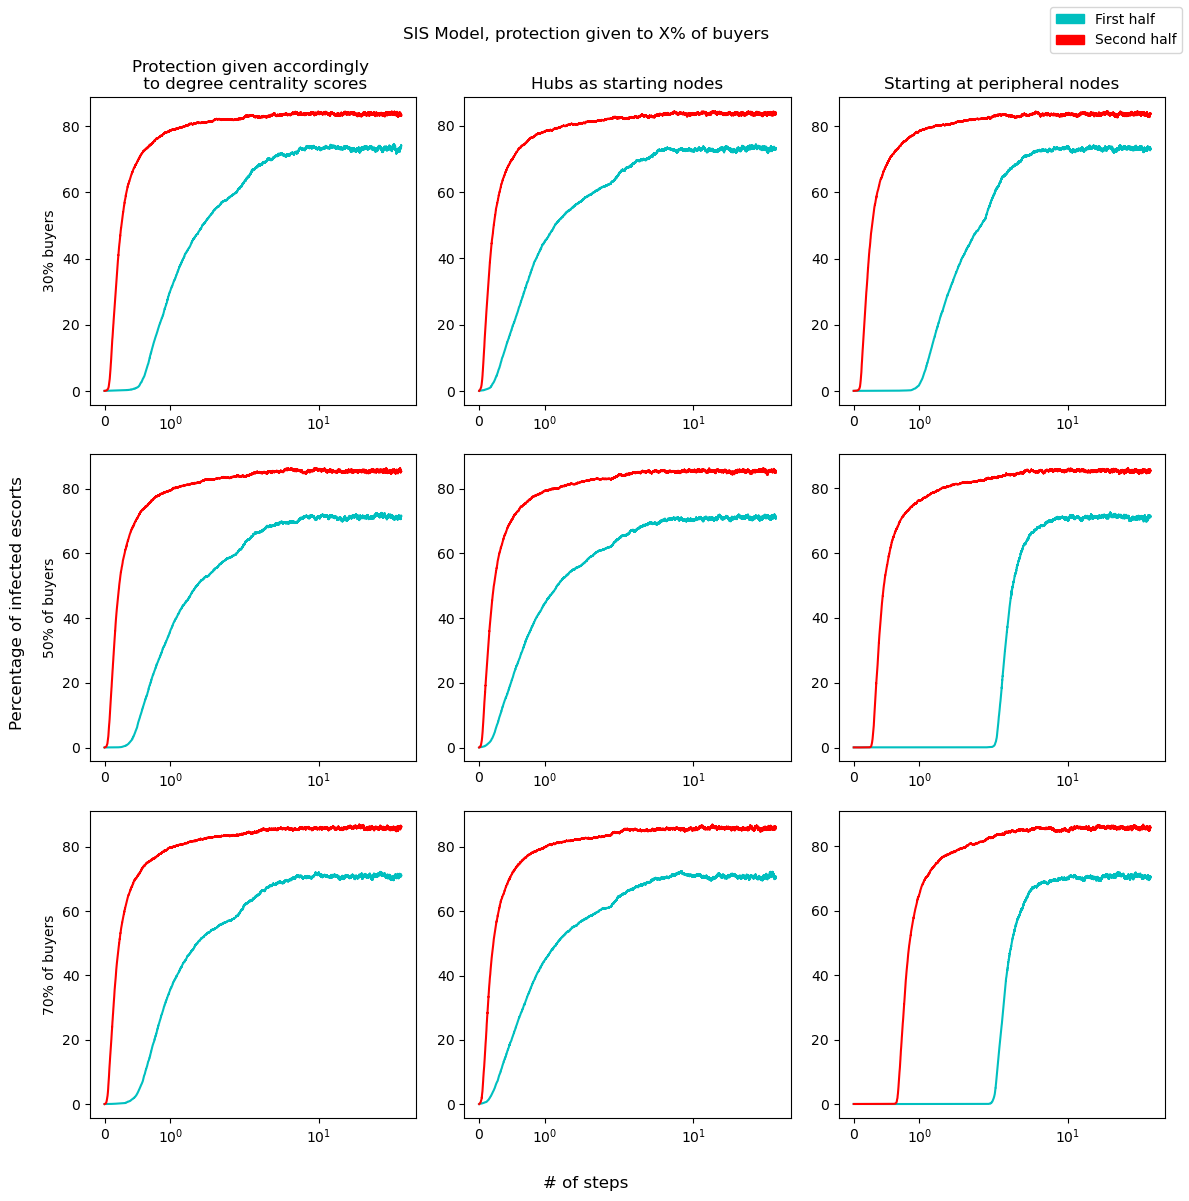

In [91]:
#Plotting simple SI model, protection given to 50% of buyers
fig, ax = plt.subplots(3, 3, figsize =(12,12))

ax[0,0].plot(protect_30_curve_SIS["top"][0], protect_30_curve_SIS["top"][2], color = 'c', label = 'top')
ax[0,0].plot(protect_30_curve_SIS["bottom"][0], protect_30_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[0,0].set_xscale('symlog')
ax[0,0].set_title('Protection given accordingly \n to degree centrality scores')
ax[0,0].set_ylabel('30% buyers')


ax[0,1].plot(protection_30_hubs_curve_SIS["top"][0], protection_30_hubs_curve_SIS["top"][2], color = 'c', label = 'top')
ax[0,1].plot(protection_30_hubs_curve_SIS["bottom"][0], protection_30_hubs_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[0,1].set_xscale('symlog')
ax[0,1].set_title('Hubs as starting nodes')


ax[0,2].plot(protection_30_peri_curve_SIS["top"][0], protection_30_peri_curve_SIS["top"][2], color = 'c', label = 'top')
ax[0,2].plot(protection_30_peri_curve_SIS["bottom"][0], protection_30_peri_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[0,2].set_xscale('symlog')
ax[0,2].set_title('Starting at peripheral nodes')

ax[1,0].plot(protect_50_curve_SIS["top"][0], protect_50_curve_SIS["top"][2], color = 'c', label = 'top')
ax[1,0].plot(protect_50_curve_SIS["bottom"][0], protect_50_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[1,0].set_xscale('symlog')
ax[1,0].set_ylabel('50% of buyers')


ax[1,1].plot(protection_50_hubs_curve_SIS["top"][0], protection_50_hubs_curve_SIS["top"][2], color = 'c', label = 'top')
ax[1,1].plot(protection_50_hubs_curve_SIS["bottom"][0], protection_50_hubs_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[1,1].set_xscale('symlog')


ax[1,2].plot(protection_50_peri_curve_SIS["top"][0], protection_50_peri_curve_SIS["top"][2], color = 'c', label = 'top')
ax[1,2].plot(protection_50_peri_curve_SIS["bottom"][0], protection_50_peri_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[1,2].set_xscale('symlog')

ax[2,0].plot(protect_70_curve_SIS["top"][0], protect_70_curve_SIS["top"][2], color = 'c', label = 'top')
ax[2,0].plot(protect_70_curve_SIS["bottom"][0], protect_70_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[2,0].set_xscale('symlog')
ax[2,0].set_ylabel('70% of buyers')


ax[2,1].plot(protection_70_hubs_curve_SIS["top"][0], protection_70_hubs_curve_SIS["top"][2], color = 'c', label = 'top')
ax[2,1].plot(protection_70_hubs_curve_SIS["bottom"][0], protection_70_hubs_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[2,1].set_xscale('symlog')


ax[2,2].plot(protection_70_peri_curve_SIS["top"][0], protection_70_peri_curve_SIS["top"][2], color = 'c', label = 'top')
ax[2,2].plot(protection_70_peri_curve_SIS["bottom"][0], protection_70_peri_curve_SIS["bottom"][2], color = 'r', label = 'bottom')
ax[2,2].set_xscale('symlog')

fig.supxlabel('# of steps')
fig.supylabel('Percentage of infected escorts')
fig.suptitle('SIS Model, protection given to X% of buyers')

fig.tight_layout(pad =1.5)

green_patch = mpatches.Patch(color='c', label='First half') 
blue_patch = mpatches.Patch(color='r', label='Second half') 
fig.legend(handles=[green_patch, blue_patch], loc='upper right') 

plt.show()

In [92]:
#Friends paradox

#Friends paradox for 50% people with condoms

b_degrees = nx.degree(proj_G_b)
for_sampling = [] #list consisting of buyers with friends

for k,v in b_degrees(): #making sure they have at least 1 friend
    if v>0:
        for_sampling.append(k)



In [143]:
def add(a,b):
    return a+b

friends_curve = defaultdict(lambda : defaultdict(float))
friends_curve['t'] = [0]*175671
friends_curve['S'] =[0]*175671
friends_curve['I'] =[0]*175671
for run in range(10):
   print(f'Run number {run}')
   condom_distributed_to = []

   while len(condom_distributed_to) != int((len(proj_G_b.nodes()))/2): #making sure it's 50% of guys
      first_random = random.sample(for_sampling, 1 )
      r_neighbors = [neighbor for neighbor in proj_G_b.neighbors(first_random[0])]
      neighbor = random.sample(r_neighbors, 1)
      if neighbor not in condom_distributed_to:
         condom_distributed_to.append(neighbor)
      else:
         pass
   df_friends = give_condom(df_constant.copy(), condom_distributed_to)
   G_friends = nx.from_pandas_edgelist(df_friends, 'n1', 'n2', 'e')
   pG_friends = nx.bipartite.generic_weighted_projected_graph(G_friends, nodes = df_friends.n2.unique(), weight_function= weightz)
   # The seed set should be the same for both models
   i_nodes_friends = set(random.sample(list(set(pG_friends.nodes)), 3))

   t, S, I = EoN.fast_SIS(pG_friends, tau=0.99, gamma =0.3, initial_infecteds=i_nodes_friends, tmax=50, transmission_weight = 'weight')
   friends_curve['t'] = list(map(add, friends_curve['t'], t))
   friends_curve['I'] = list(map(add, friends_curve['I'], (I/len(pG_raw.nodes))*10))

Run number 0
Run number 1
Run number 2
Run number 3
Run number 4
Run number 5
Run number 6
Run number 7
Run number 8
Run number 9


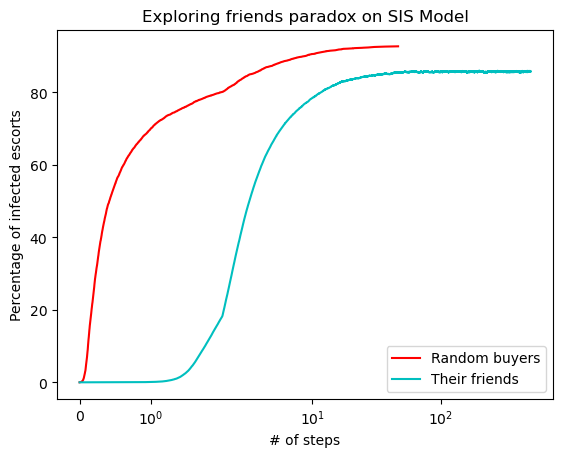

In [147]:


plt.plot(basic_curve["condoms"][0], basic_curve["condoms"][2], color = 'r', label = 'Random buyers')
plt.plot(friends_curve["t"], friends_curve['I'], color = 'c', label = 'Their friends')
plt.xscale('symlog')
plt.legend(loc='lower right')

plt.xlabel('# of steps')
plt.ylabel('Percentage of infected escorts')
plt.title('Exploring friends paradox on SIS Model')


plt.show()